#### Import some libraries

In [1]:
# Dependency
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import tqdm

from PIL import Image

COLORS = [
    (255, 0, 0),   # red
    (0, 255, 0),  # green
    (0, 0, 255),   # blue
    (255, 255, 0), # yellow
    (255, 0, 255), # magenta
]

#### Load Image
What you should do is to implement Z-score normalization in `load()`:

In [2]:
import cv2


def load(image_path):
    image = cv2.imread(image_path)
    h, w, c = image.shape

    # TODO: please normalize image_pixl using Z-score
    image = np.reshape(image, (h*w, c))
    _mean = np.array([np.mean(image[:,channel]) for channel in range(c)])
    _std = np.array([np.std(image[:,channel]) for channel in range(c)])
    for channel in range(c):
        image[:,channel] = (image[:,channel] - _mean[channel]) / _std[channel]
    image_norm = np.array(image)

    return h, w, c, image_norm


#### Initialize means, covariance matrices and mixing coefficients of GMM
k-means is used to initialize means, covariance matrices and mixing coefficients of GMM

In [3]:
def kmeans(n_cluster, image_pixl):
    kmeans = KMeans(n_clusters=n_cluster)# instantiate a K-means
    labels = kmeans.fit_predict(image_pixl)# fit and get clustering result
    initial_mus = kmeans.cluster_centers_# get centroids
    initial_priors, initial_covs = [], []
    #Followings are for initialization:
    for i in range(n_cluster):
        datas = image_pixl[labels == i, ...].T
        initial_covs.append(np.cov(datas))
        initial_priors.append(datas.shape[1] / len(labels))
    return np.array(initial_mus), np.array(initial_priors), np.array(initial_covs)

#### Implement GMM algorithm
We use EM algorithm to refine GMM's parameters.

Although it may be not easy for some students to derive EM formula for GMM, GMM isn't very difficult to implement once you have the formula. Therefore, to help you understand GMM more, there are still some blanks for you to fill in.

In [4]:
class GMM:
    def __init__(self, ncomp, initial_mus, initial_covs, initial_priors):
        """
        :param ncomp:           the number of clusters
        :param initial_mus:     initial means
        :param initial_covs:    initial covariance matrices
        :param initial_priors:  initial mixing coefficients
        """
        self.ncomp = ncomp
        self.mus = np.asarray(initial_mus)
        self.covs = np.asarray(initial_covs)
        self.priors = np.asarray(initial_priors)

    def inference(self, datas):
        """
        E-step
        :param datas:   original data
        :return:        posterior probability (gamma) and log likelihood
        """
        probs = []
        for i in range(self.ncomp):
            mu, cov, prior = self.mus[i, :], self.covs[i, :, :], self.priors[i]
            prob = prior * \
                multivariate_normal.pdf(
                    datas, mean=mu, cov=cov, allow_singular=True)
            probs.append(np.expand_dims(prob, -1))
        preds = np.concatenate(probs, axis=1)

        preds_sum = np.sum(preds, axis=-1)

        # TODO: calc log likelihood
        log_likelihood = np.sum(np.log(preds_sum))

        # TODO: calc gamma
        gamma = np.array([preds[x] / preds_sum[x] for x in range(len(preds))])

        return gamma, log_likelihood

    def update(self, datas, gamma):
        """
        M-step
        :param datas:   original data
        :param gamma:    gamma
        :return:
        """
        new_mus, new_covs, new_priors = [], [], []
        soft_counts = np.sum(gamma, axis=0)
        for i in range(self.ncomp):
            # TODO: calc mu
            new_mu = np.sum([datas[n] * gamma[n,i] for n in range(len(datas))], axis=0) / soft_counts[i]
            new_mus.append(new_mu)

            # TODO: calc cov
            new_cov = np.sum([gamma[n,i] * (np.asmatrix(datas[n] - new_mu).T @ np.asmatrix(datas[n] - new_mu)) for n in range(len(datas))], axis=0) / soft_counts[i]
            new_covs.append(new_cov)
  
            # TODO: calc mixing coefficients
            new_prior = soft_counts[i] / len(datas)
            new_priors.append(new_prior)

        self.mus = np.asarray(new_mus)
        self.covs = np.asarray(new_covs)
        self.priors = np.asarray(new_priors)

    def fit(self, data, iteration):
        prev_log_liklihood = None

        bar = tqdm.tqdm(total=iteration)
        for i in range(iteration):
            gamma, log_likelihood = self.inference(data)
            self.update(data, gamma)
            if prev_log_liklihood is not None and abs(log_likelihood - prev_log_liklihood) < 1e-10:
                break
            prev_log_likelihood = log_likelihood

            bar.update()
            bar.set_postfix({"log likelihood": log_likelihood})

#### Display
We use `matplotlib` to display what we segment, you can check the code in `visualize()`

In [5]:
from PIL import Image
import matplotlib.pyplot as plt


def visualize(gmm, image, ncomp, ih, iw):
    beliefs, log_likelihood = gmm.inference(image)
    map_beliefs = np.reshape(beliefs, (ih, iw, ncomp))
    segmented_map = np.zeros((ih, iw, 3))
    for i in range(ih):
        for j in range(iw):
            hard_belief = np.argmax(map_beliefs[i, j, :])
            segmented_map[i, j, :] = np.asarray(COLORS[hard_belief]) / 255.0
    plt.imshow(segmented_map)
    plt.show()

100%|██████████| 100/100 [21:06<00:00, 12.66s/it, log likelihood=-1.36e+6]


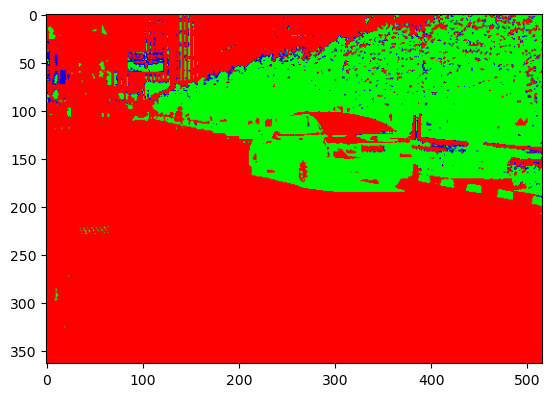

In [6]:
img_path = './data/original/sample.png'
cluster_n = 3

h, w, c, img = load(img_path)
initial_mus, initial_priors, initial_covs = kmeans(cluster_n, img)

model = GMM(cluster_n, initial_mus, initial_covs, initial_priors)
model.fit(img, 100)
visualize(model, img, cluster_n, h, w)

### Questions(3 points)
1. What are the strengths of GMM; when does it perform well?

    - GMM returns possibilities of points belong to clusters, hence is suitable for more types of tasks, especially when they involve risk criteria.
    - GMM has good mathematical properties and better computation performance.
    - GMM can better fit data with non-circular shapes.
    - GMM is the generative model, it reaches the asymptotic error faster than the deterministic model. What's more, it can simulate the distribution of any variable in the model and it is easy to extend to unsupervised learning.
    - It performs well when the task is unlabeled/unsupervised clustering.

2. What are the weaknesses of GMM; when does it perform poorly?

    - EM converges well but doesn't promise to find the global maximum value, even though it may reach the local maximum value.
    - GMM performs unsatisfactorily at high-dimensional data. Especially, it is hard to estimate covariance by insufficient samples.
    - GMM belongs to the Gaussian distribution. The number of distributions is unknown, it requires users to tune it by themselves.
    - It performs poorly when it is not well tuned, and hence local solution was found.

3. What makes GMM a good candidate for the clustering problem, if you have enough knowledge about the data?

    - When the data is low-dimensional and large-sized, GMM will be a good candidate.